## Imports

In [1]:
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Settings and Dataset

In [2]:
##########################
### SETTINGS
##########################

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)

# Hyperparameters
random_seed = 1
learning_rate = 0.0005
num_epochs = 10
batch_size = 128

# Architecture
num_features = 784
num_classes = 10


##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Device: cuda:0
Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


## Model

In [3]:
##########################
### MODEL
##########################


class VGG16(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(VGG16, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        self.block_1 = nn.Sequential(
                nn.Conv2d(in_channels=1,
                          out_channels=64,
                          kernel_size=3,
                          stride=1,
                          # (1(32-1)- 32 + 3)/2 = 1
                          padding=1), 
                nn.ReLU(),
                nn.Conv2d(in_channels=64,
                          out_channels=64,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3,
                             stride=2)
        )
        
        self.block_2 = nn.Sequential(
                nn.Conv2d(in_channels=64,
                          out_channels=128,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=128,
                          out_channels=128,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=3,
                             stride=2)
        )
        
        self.block_3 = nn.Sequential(        
                nn.Conv2d(in_channels=128,
                          out_channels=256,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2,
                             stride=1)
        )
        
          
        self.block_4 = nn.Sequential(   
                nn.Conv2d(in_channels=256,
                          out_channels=512,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.ReLU(),            
                nn.MaxPool2d(kernel_size=2,
                             stride=2)
        )
        
        self.block_5 = nn.Sequential(
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=3,
                          stride=1,
                          padding=1),
                nn.ReLU(),    
                nn.MaxPool2d(kernel_size=2,
                             stride=2)             
        )
            
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            # nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )
            
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.detach().zero_()
                    
        #self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        
    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        #x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)

        return logits, probas

    
torch.manual_seed(random_seed)
model = VGG16(num_features=num_features,
              num_classes=num_classes)

model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

## Training

In [4]:
def compute_accuracy(model, data_loader):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss
    
total_cost = []
total_accuracy = []

f = open("training_log_vgg_mnist.txt", "w")    


start_time = time.time()
for epoch in range(num_epochs):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            f.write('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f\n' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))
            f.write('Time elapsed: %.2f min\n' % ((time.time() - start_time)/60))
            total_cost.append(float(compute_epoch_loss(model, train_loader)))
            total_accuracy.append(float(compute_accuracy(model, train_loader)))

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% |  Loss: %.3f' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader),
              compute_epoch_loss(model, train_loader)))
        f.write('Epoch: %03d/%03d | Train: %.3f%%\n' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader)))
        f.write("------------------------------------\n")


    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

f.close()

Epoch: 001/010 | Batch 0000/0469 | Cost: 2.7370
Epoch: 001/010 | Batch 0050/0469 | Cost: 2.0569
Epoch: 001/010 | Batch 0100/0469 | Cost: 0.8443
Epoch: 001/010 | Batch 0150/0469 | Cost: 0.3922
Epoch: 001/010 | Batch 0200/0469 | Cost: 0.1433
Epoch: 001/010 | Batch 0250/0469 | Cost: 0.2447
Epoch: 001/010 | Batch 0300/0469 | Cost: 0.1028
Epoch: 001/010 | Batch 0350/0469 | Cost: 0.0868
Epoch: 001/010 | Batch 0400/0469 | Cost: 0.1488
Epoch: 001/010 | Batch 0450/0469 | Cost: 0.3066
Epoch: 001/010 | Train: 97.732% |  Loss: 0.087
Time elapsed: 2.30 min
Epoch: 002/010 | Batch 0000/0469 | Cost: 0.1442
Epoch: 002/010 | Batch 0050/0469 | Cost: 0.0681
Epoch: 002/010 | Batch 0100/0469 | Cost: 0.0702
Epoch: 002/010 | Batch 0150/0469 | Cost: 0.0257
Epoch: 002/010 | Batch 0200/0469 | Cost: 0.0961
Epoch: 002/010 | Batch 0250/0469 | Cost: 0.1364
Epoch: 002/010 | Batch 0300/0469 | Cost: 0.0389
Epoch: 002/010 | Batch 0350/0469 | Cost: 0.0238
Epoch: 002/010 | Batch 0400/0469 | Cost: 0.1142
Epoch: 002/010 | B

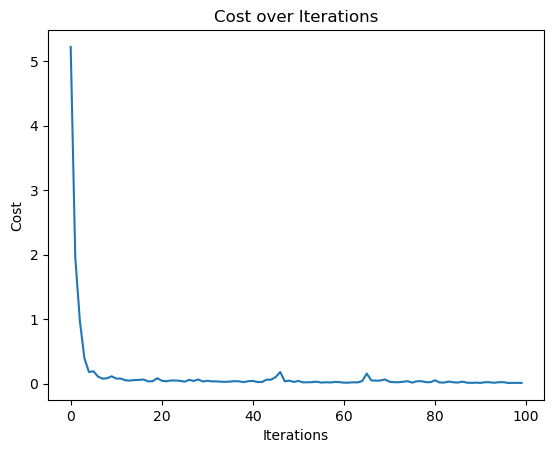

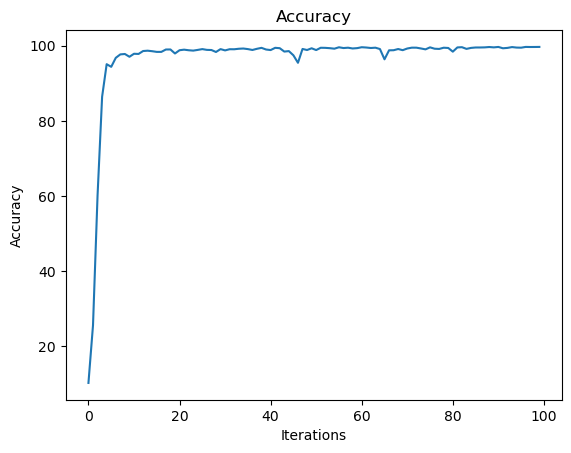

In [5]:
cst = plt.figure()
plt.title("Cost over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.plot(total_cost)
plt.savefig("cost_graph_vgg_mnist.png")

acc = plt.figure()
plt.title("Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.plot(total_accuracy)
plt.savefig("acc_graph_vgg_mnist.png")

## Evaluation

In [6]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 99.30%
